## Import library

In [2]:
# from ContestHelper import *
import os
import gc
cur_path = os.getcwd()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score



In [3]:
from typing import Tuple

TRAIN_PATH = "/kaggle/input/predict-student-performance-from-game-play/train.csv"

def createPreparedFeatures(df:pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(by=['session_id', 'elapsed_time'])
    df["full_event_name"] = df["name"].astype("str") + "_" + df["event_name"].astype("str")

    df["delta_absolute_coor_x"] = (df["room_coor_x"] + df["screen_coor_x"]).diff(1).fillna(0)
    df["delta_absolute_coor_y"] = (df["room_coor_y"] + df["screen_coor_y"]).diff(1).fillna(0)

    df["radius_absolute_coor"] = np.sqrt(df["delta_absolute_coor_x"]**2 + df["delta_absolute_coor_y"]**2)
    df["tangent_absolute_coor"] = df["delta_absolute_coor_y"]/df["delta_absolute_coor_x"]

    df["page"] = df["page"].fillna(-1) + 1
    df["hover_duration"] = df["hover_duration"].fillna(0)
    return df

def prepareDataset(train_file_path:str = TRAIN_PATH) -> None:
    dtypes = {"session_id": "int64",
            "index": np.int16,
            "elapsed_time": np.int32,
            "event_name": "category",
            "name": "category",
            "level": np.int8,
            "page": np.float32,
            "room_coor_x": np.float32,
            "room_coor_y": np.float32,
            "screen_coor_x": np.float32,
            "screen_coor_y": np.float32,
            "hover_duration": np.float32,
            "text": "category",
            "fqid": "category",
            "room_fqid": "category",
            "text_fqid": "category",
            "fullscreen": np.int8,
            "hq": np.int8,
            "music": np.int8,
            "level_group": "category"
            }

    use_col = ["session_id",
            #   "index",
            "elapsed_time",
            "event_name",
            "name",
            "level",
            "page",
            "room_coor_x",
            "room_coor_y",
            "screen_coor_x",
            "screen_coor_y",
            "hover_duration",
            #   "text",
            #   "fqid",
            #   "room_fqid",
            #   "text_fqid",
            # "fullscreen",
            # "hq",
            # "music",
            "level_group"
            ]

    train_raw = pd.read_csv(train_file_path, dtype=dtypes, usecols=use_col)
    train_raw = createPreparedFeatures(train_raw)

    #Saving train file after applying create_features and remove_outliers
    train_raw[train_raw["level_group"] == "0-4"].drop("level_group", axis=1).to_pickle("train_0_4.pkl")
    print("Saving train file with level group 0-4 done!")

    train_raw[train_raw["level_group"] == "5-12"].drop("level_group", axis=1).to_pickle("train_5_12.pkl")
    print("Saving train file with level group 5-12 done!")

    train_raw[train_raw["level_group"] == "13-22"].drop("level_group", axis=1).to_pickle("train_13_22.pkl")
    print("Saving train file with level group 13-22 done!")

def removeOutliers(series:pd.Series) -> Tuple[pd.Series, float, float]:
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower_bound, upper_bound), lower_bound, upper_bound

def createTimeFeatures(df):
    df["month"] = df["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    df["day"] = df["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    df["hour"] = df["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    return df

def createDeltaElapsedTimeFeatures(df:pd.DataFrame) -> pd.DataFrame:
    df['elapsed_time_diff'] = df['elapsed_time'].diff(1).fillna(0)
    df = df.drop('elapsed_time', axis=1)
    return df

In [4]:
TRAIN_0_4_PATH = "/kaggle/input/train-data/train_0_4.pkl"
TRAIN_5_12_PATH =  "/kaggle/input/train-data/train_5_12.pkl"
TRAIN_13_22_PATH = "/kaggle/input/train-data/train_13_22.pkl"
TRAIN_LABELS_PATH = "/kaggle/input/predict-student-performance-from-game-play/train_labels.csv"

In [5]:
train_raw_0_4 = pd.read_pickle(TRAIN_0_4_PATH)
train_raw_5_12 = pd.read_pickle(TRAIN_5_12_PATH)
train_raw_13_22 = pd.read_pickle(TRAIN_13_22_PATH)

In [6]:
targets = pd.read_csv(TRAIN_LABELS_PATH)
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

## Feature engineering

In [7]:
NUM_COLS = ['level', 
            'page',
            'hover_duration',
            'room_coor_x', 'screen_coor_x',
            'room_coor_y', 'screen_coor_y',
            'delta_absolute_coor_x', 'delta_absolute_coor_y',
            'absolute_coor_x', 'absolute_coor_y',
            'radius_absolute_coor',
            'tangent_absolute_coor',
            'delta_radius_absolute_coor', 'delta_tangent_absolute_coor',
            'elapsed_time_diff']

CAT_COLS = ['full_event_name',
            "text",
            "event_name"]

FULL_EVENT_NAME = {
    "0_4": train_raw_0_4["full_event_name"].unique().tolist(),  
    "5_12": train_raw_5_12["full_event_name"].unique().tolist(),  
    "13_22": train_raw_13_22["full_event_name"].unique().tolist()  
}

SUB_LEVELS = {'0_4': [1, 2, 3, 4],
              '5_12': [5, 6, 7, 8, 9, 10, 11, 12],
              '13_22': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]}

In [8]:
def agg_by_elapsed_time_diff(col_name, iter_col, feature_suffix):
    agg = [
        *[pl.col(col_name).filter(pl.col(col_name) == c).count().alias(f"{c}_{col_name}_{feature_suffix}")
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).std().alias(f"{c}_{col_name}_ET_std_{feature_suffix}") 
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).mean().alias(f"{c}_{col_name}_ET_mean_{feature_suffix}") 
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).sum().alias(f"{c}_{col_name}_ET_sum_{feature_suffix}") 
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).median().alias(f"{c}_{col_name}_ET_median_{feature_suffix}") 
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).max().alias(f"{c}_{col_name}_ET_max_{feature_suffix}") 
          for c in iter_col]
    ]
    return agg

def feature_engineer_pl(x, group, feature_suffix):  
     
    full_event_names = FULL_EVENT_NAME[group]
    levels = SUB_LEVELS[group]

    x = pl.from_pandas(x)
    aggs = [
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") 
          for c in CAT_COLS],

        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).quantile(0.25).alias(f"{c}_q25_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).quantile(0.75).alias(f"{c}_q75_{feature_suffix}") 
          for c in NUM_COLS]]
    
    aggs.extend(agg_by_elapsed_time_diff("full_event_name", full_event_names, feature_suffix))
    aggs.extend(agg_by_elapsed_time_diff("level", levels, feature_suffix))

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")
    return df.to_pandas()

In [9]:
def pipeline(df:pd.DataFrame, grp) -> pd.DataFrame:
    df = createDeltaElapsedTimeFeatures(df)
    df = feature_engineer_pl(df, grp, grp)
    df = createTimeFeatures(df)
    df = df.set_index('session_id')
    return df

In [10]:
df1 = pipeline(train_raw_0_4, "0_4")
print("df1 done!")
df2 = pipeline(train_raw_5_12, "5_12")
print("df2 done!")
df3 = pipeline(train_raw_13_22, "13_22")
print("df3 done!")

del train_raw_0_4, train_raw_5_12, train_raw_13_22
gc.collect()

df1 done!
df2 done!
df3 done!


60

In [11]:
# Drop most-null value columns and constant columns
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)

for col in df1.columns:
    if (df1[col].nunique()==1):
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2.columns:
    if (df2[col].nunique()==1):
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3.columns:
    if (df3[col].nunique()==1):
        drop3.append(col)
print("*********df3 DONE*********")
print(len(drop1), len(drop2), len(drop3))

*********df1 DONE*********
*********df2 DONE*********
*********df3 DONE*********
26 14 9


In [12]:
FEATURES1 = [c for c in df1.columns if c not in drop1]
FEATURES2 = [c for c in df2.columns if c not in drop2]
FEATURES3 = [c for c in df3.columns if c not in drop3]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 230 266 283 features
We will train with 23562 users info


In [13]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'n_estimators': 400,
    'learning_rate': 0.02,
    'max_depth': 4,
    'alpha': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'random_state': 42
}

## Train model

In [14]:
kf = KFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}
importants = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(kf.split(df1)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: 
            grp = '0-4'
            FEATURES = FEATURES1
            # TRAIN DATA
            train_x = df1.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df1.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        elif t<=13: 
            grp = '5-12'
            FEATURES = FEATURES2
            # TRAIN DATA
            train_x = df2.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df2.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        elif t<=22: 
            grp = '13-22'
            FEATURES = FEATURES3
            # TRAIN DATA
            train_x = df3.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df3.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
    
        # TRAIN MODEL        
        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{i}_{grp}_{t}'] = clf
        importants[f'{i}_{grp}_{t}'] = clf.feature_importances_
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################

#########################
### Fold 2
#########################

#########################
### Fold 3
#########################

#########################
### Fold 4
#########################

#########################
### Fold 5
#########################



In [15]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

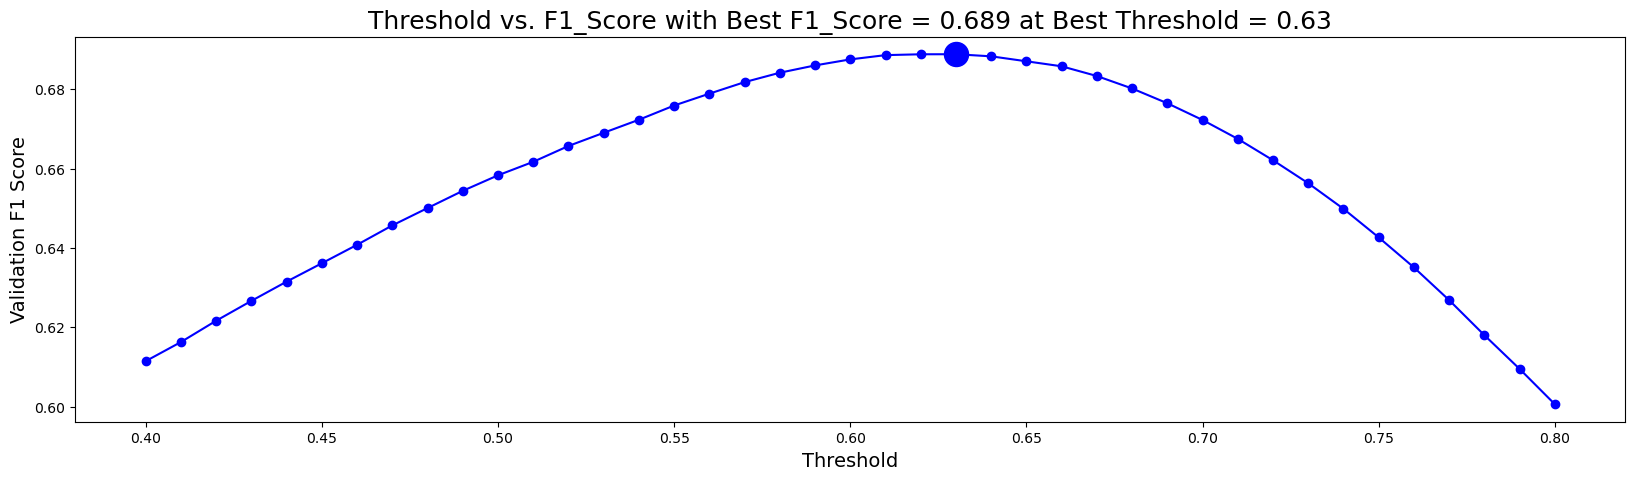

In [16]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [17]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6642873751681047
Q1: F1 = 0.5137710531884824
Q2: F1 = 0.5093820313910683
Q3: F1 = 0.6635484849798431
Q4: F1 = 0.6081115727287874
Q5: F1 = 0.6221288830586436
Q6: F1 = 0.6112048890736099
Q7: F1 = 0.5543479215135421
Q8: F1 = 0.6186318059108767
Q9: F1 = 0.5476790776652019
Q10: F1 = 0.598508618823773
Q11: F1 = 0.5059523975660103
Q12: F1 = 0.4547875735115881
Q13: F1 = 0.620640010470519
Q14: F1 = 0.5476384072026914
Q15: F1 = 0.4928176355542969
Q16: F1 = 0.5503866859425793
Q17: F1 = 0.49733306545334977
==> Overall F1 = 0.6888485210633453


## Remove less importance features

In [18]:
summary_importants = {}
for i in range(1, 19):
    if i<=3: 
        grp = '0-4'
    elif i<=13: 
        grp = '5-12'
    elif i<=22: 
        grp = '13-22'
    summary_importants[f"{i}"] = importants[f"0_{grp}_{i}"] + importants[f"1_{grp}_{i}"] + importants[f"2_{grp}_{i}"] + importants[f"3_{grp}_{i}"] + importants[f"4_{grp}_{i}"]

feature_scores = {}
for i in range(1, 19):
    if i<=3: 
        feature = FEATURES1
    elif i<=13: 
        feature = FEATURES2
    elif i<=22: 
        feature = FEATURES3
    feature_scores[f"{i}"] = pd.Series(summary_importants[f"{i}"], index=feature).sort_values(ascending=False)

In [19]:
def plotMostImportances(q, nfeatures=5):
    f, ax = plt.subplots(figsize=(8, 3))
    ax = sns.barplot(x=feature_scores[f"{q}"][:nfeatures], y=feature_scores[f"{q}"].index[:nfeatures])
    ax.set_title(f"Features importance of question {q}")
    ax.set_xlabel("Feature importance score")
    ax.set_ylabel("Features")
    plt.show()

def plotLeastImportances(q, nfeatures=5):
    f, ax = plt.subplots(figsize=(8, 3))
    ax = sns.barplot(x=feature_scores[f"{q}"][-nfeatures:], y=feature_scores[f"{q}"].index[-nfeatures:])
    ax.set_title(f"Features importance of question {q}")
    ax.set_xlabel("Feature importance score")
    ax.set_ylabel("Features")
    plt.show()

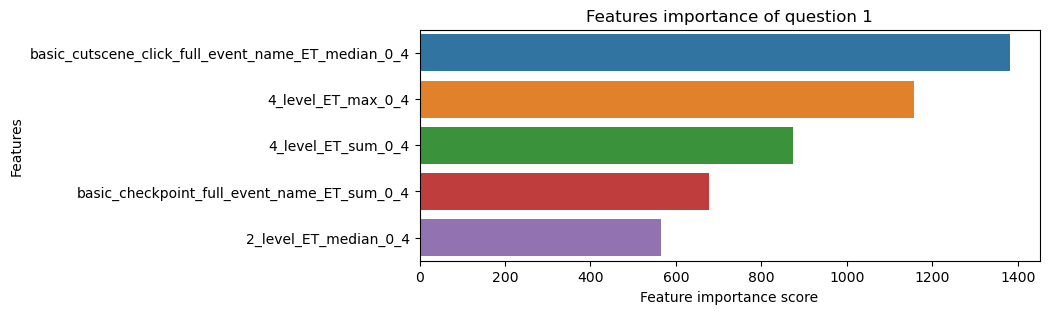

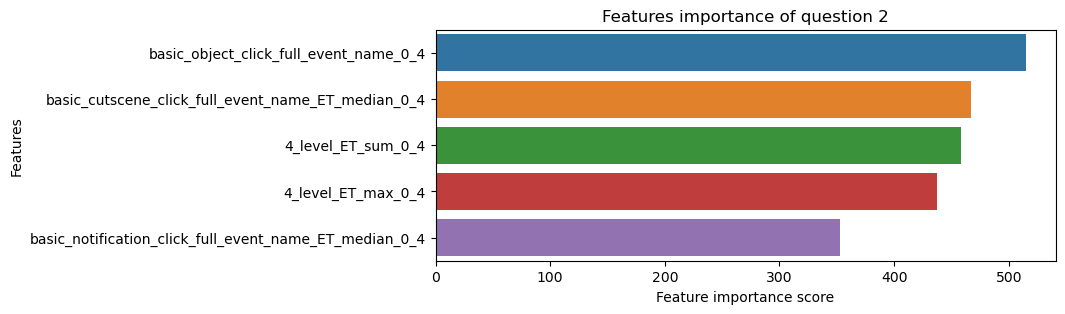

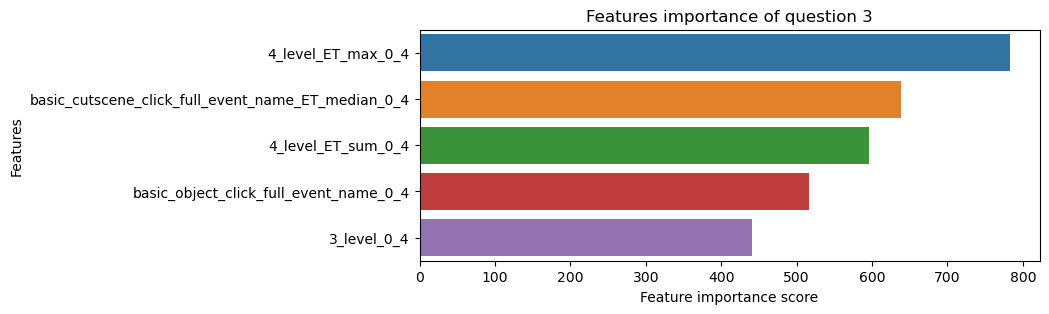

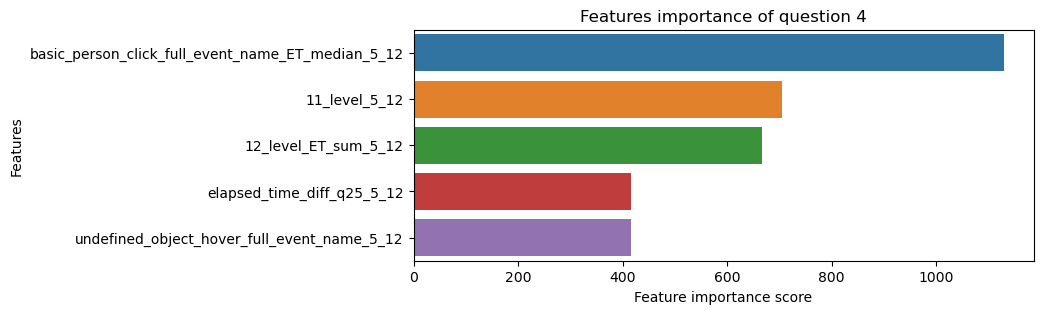

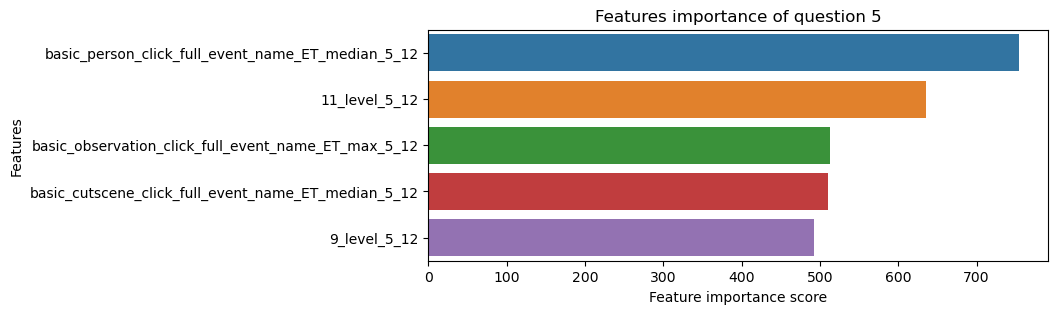

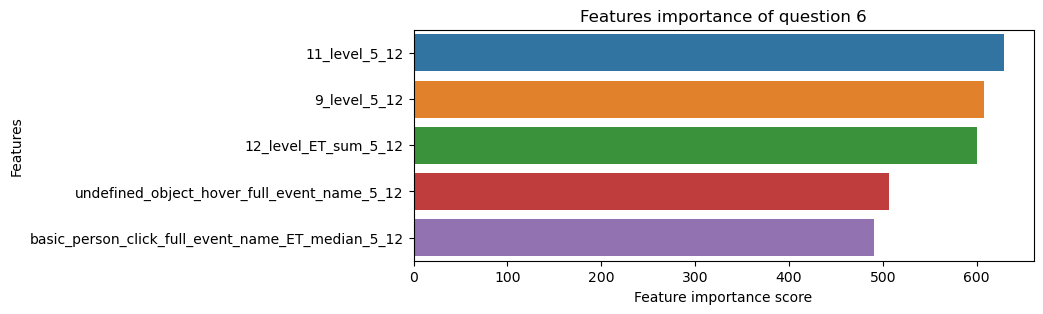

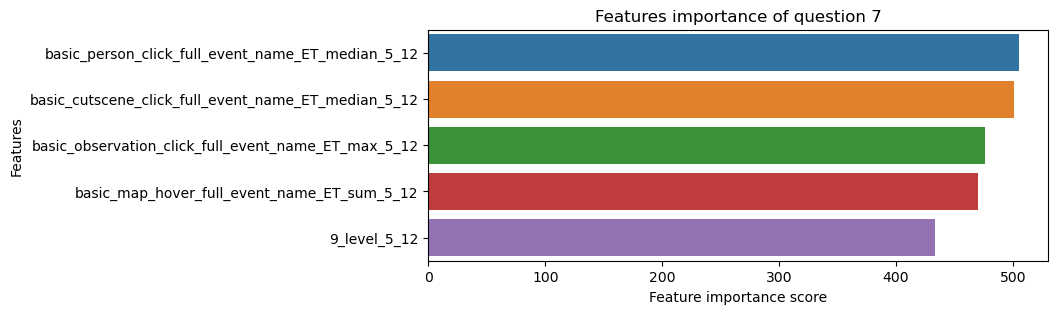

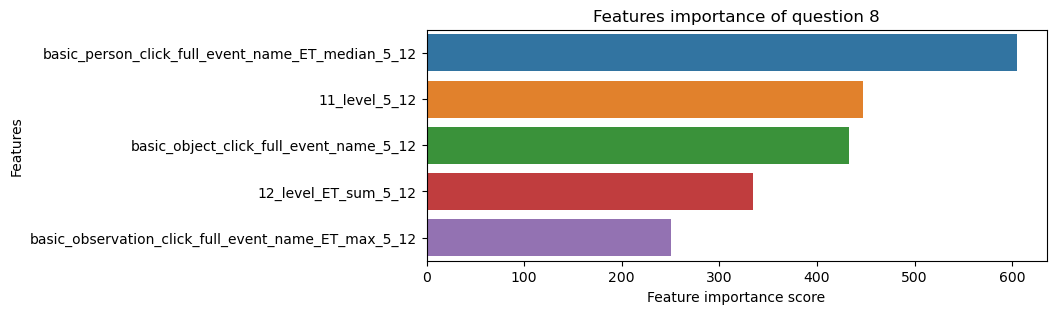

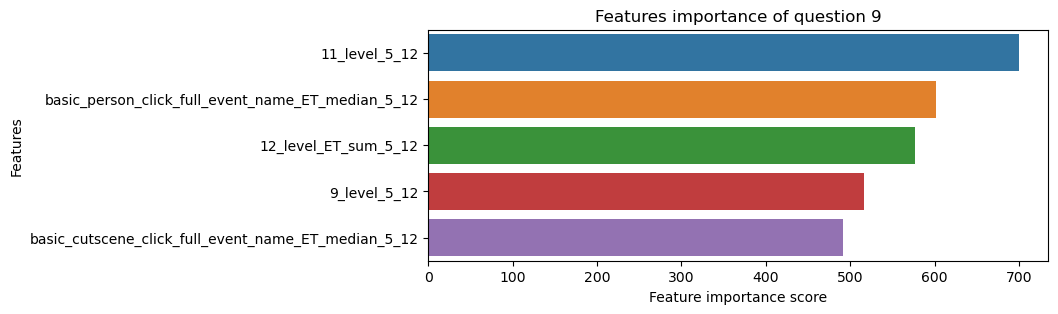

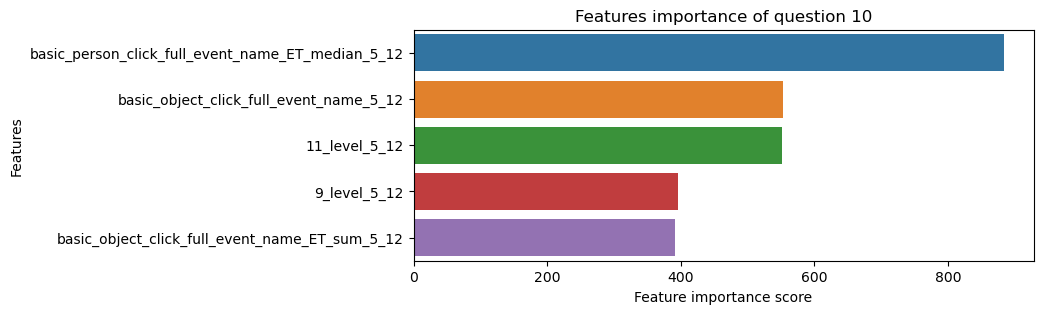

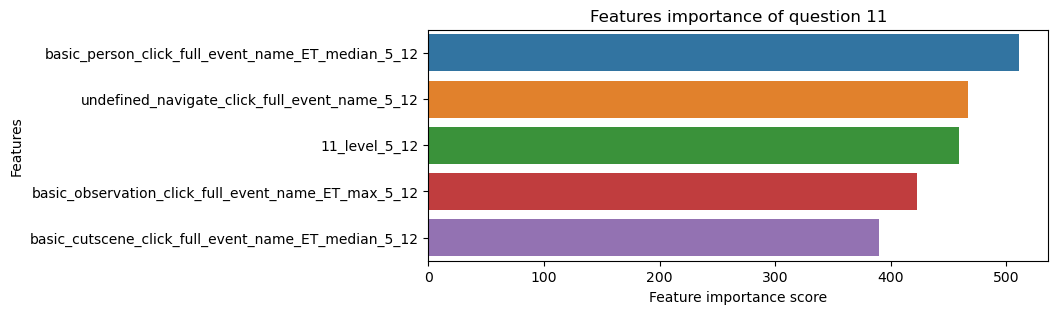

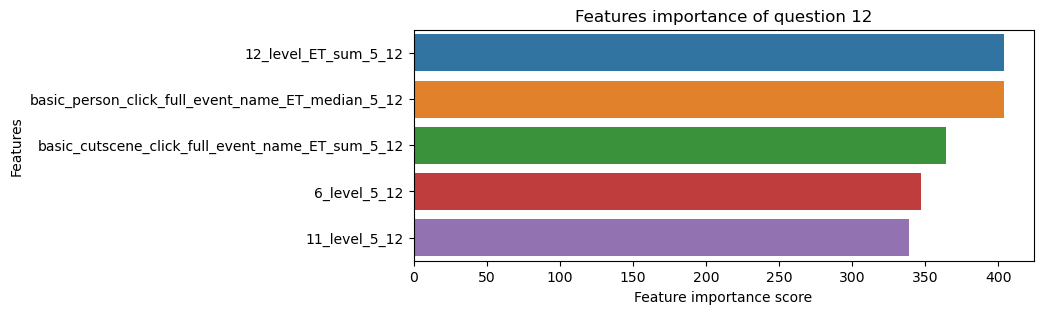

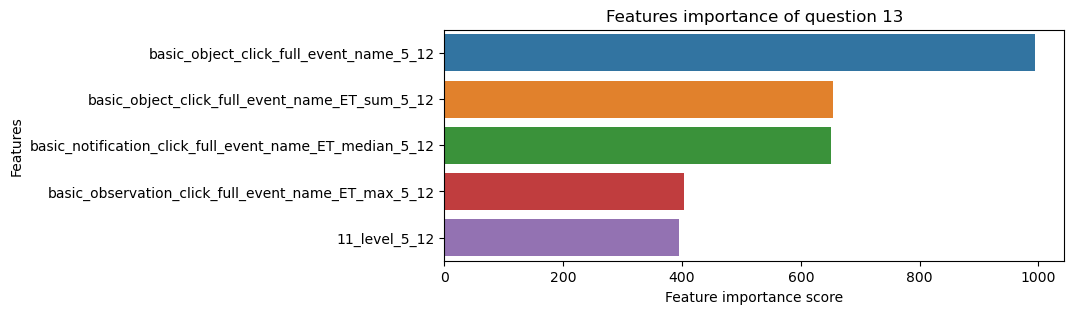

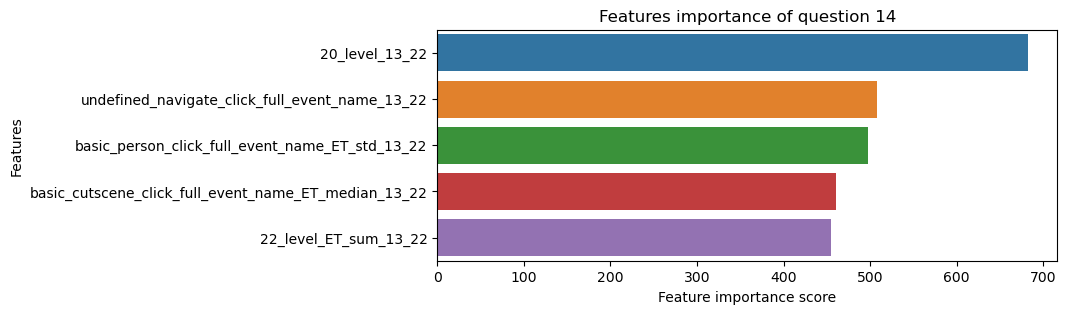

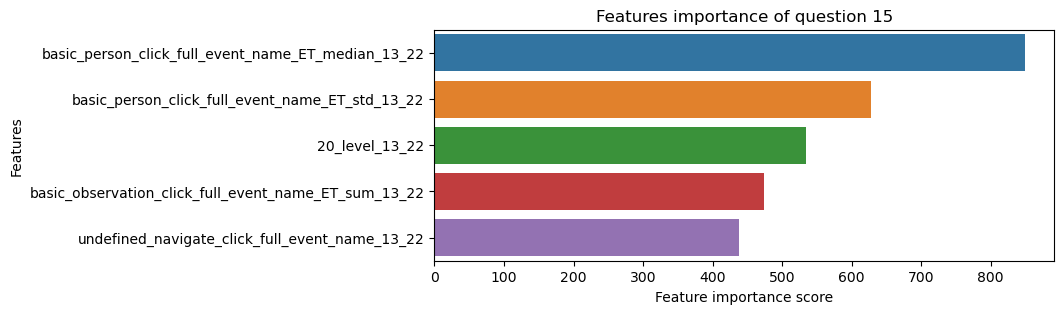

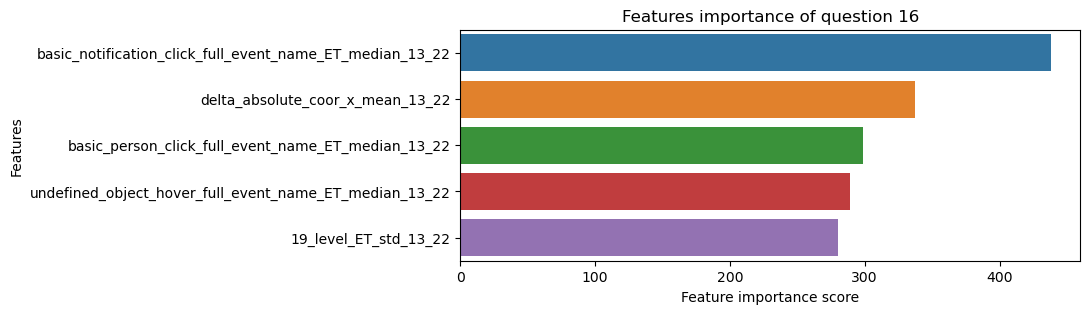

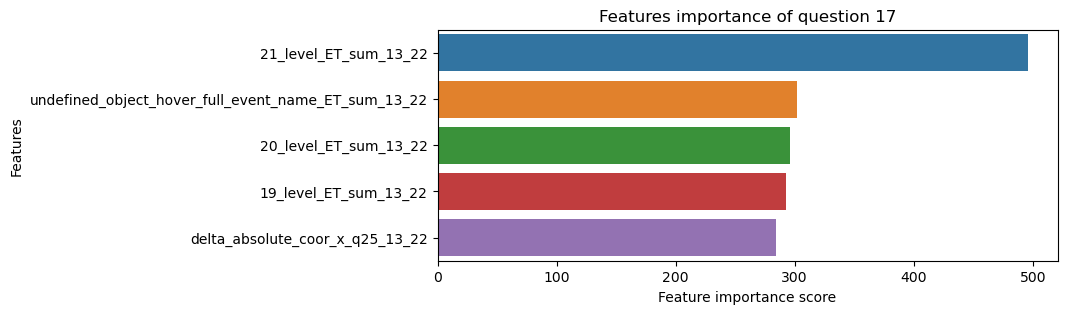

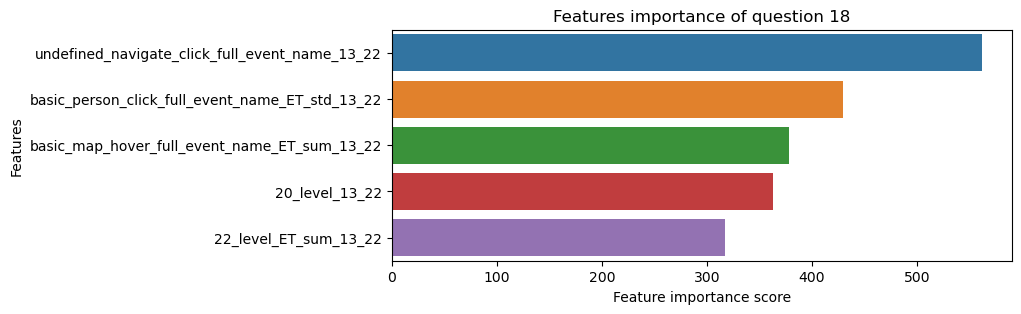

In [20]:
for q in range(1, 19):
    plotMostImportances(q)

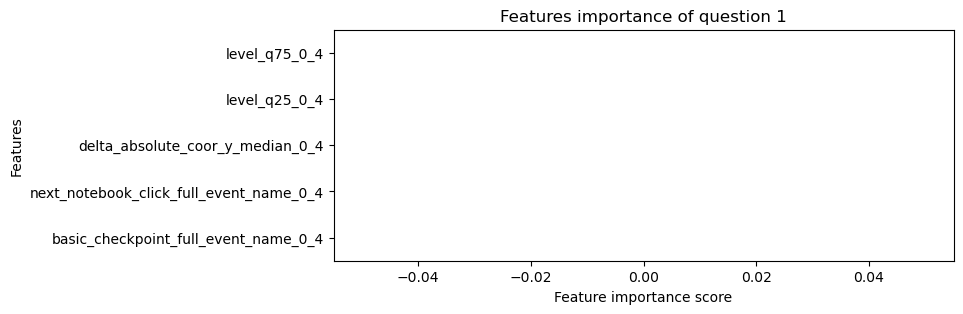

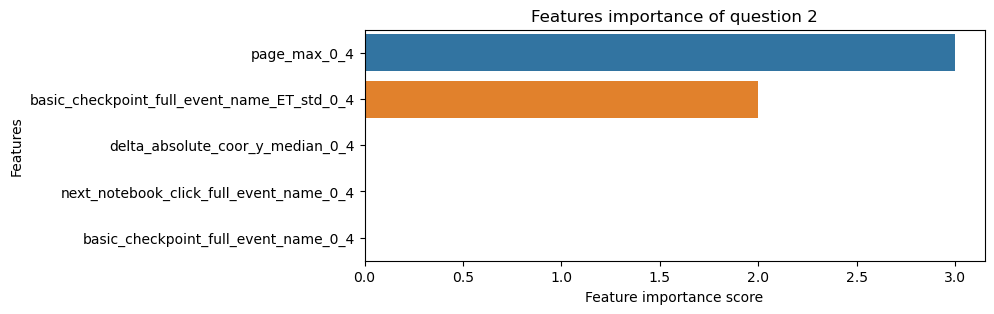

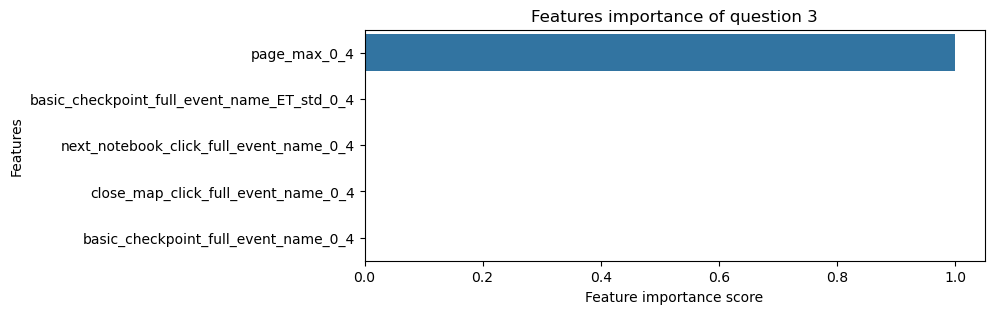

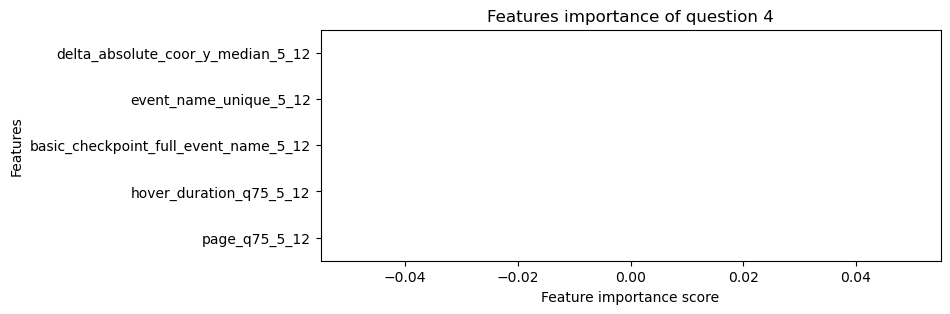

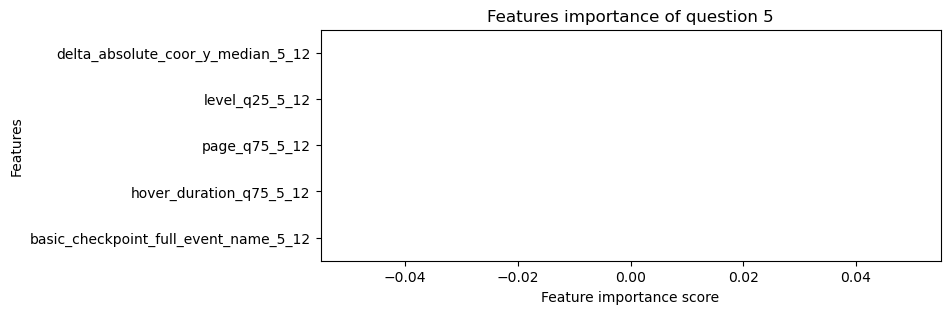

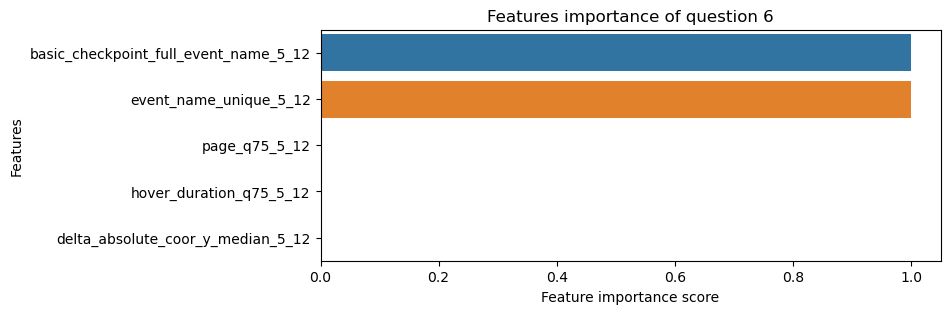

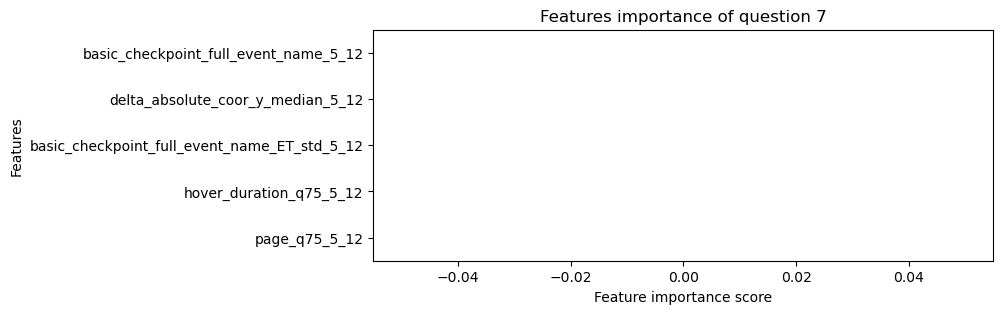

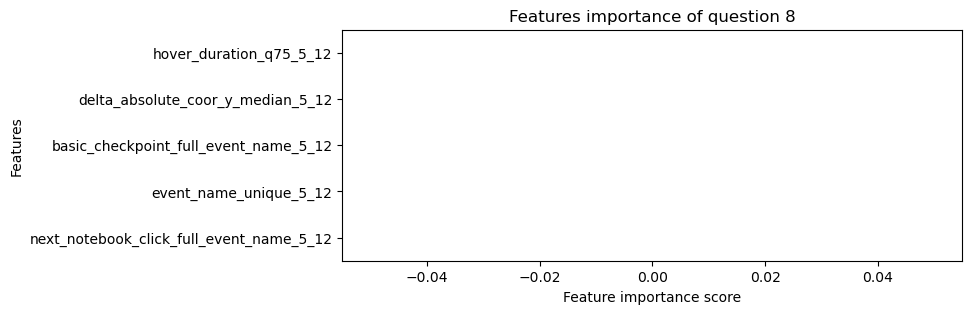

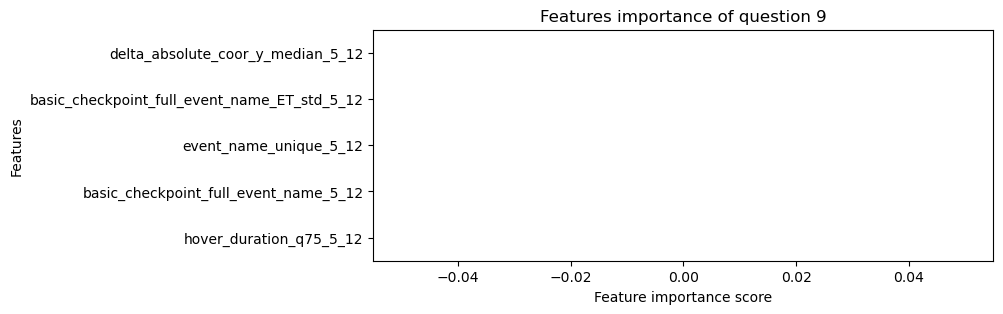

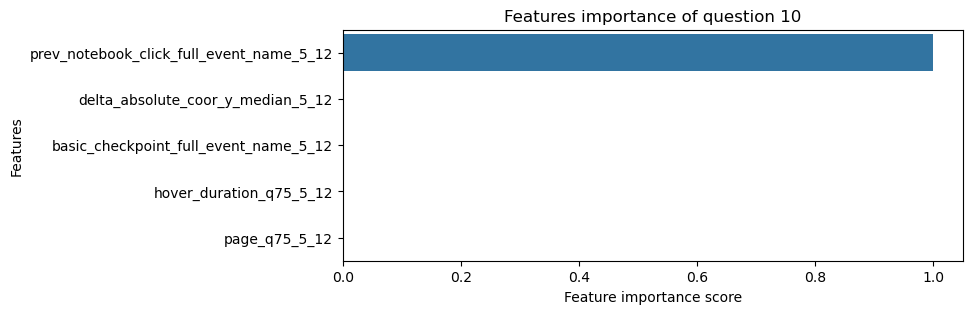

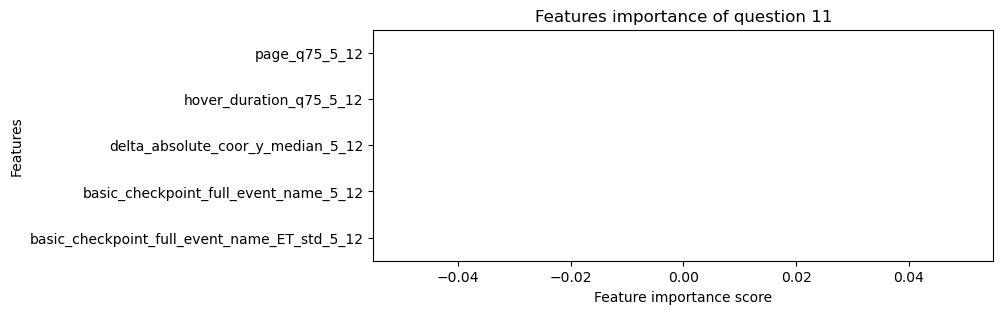

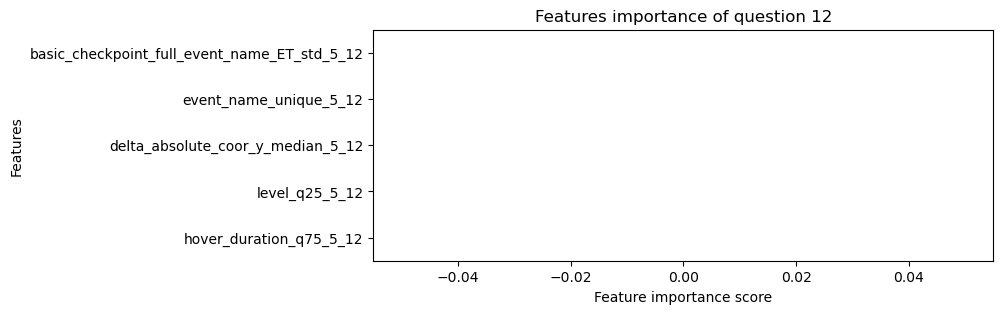

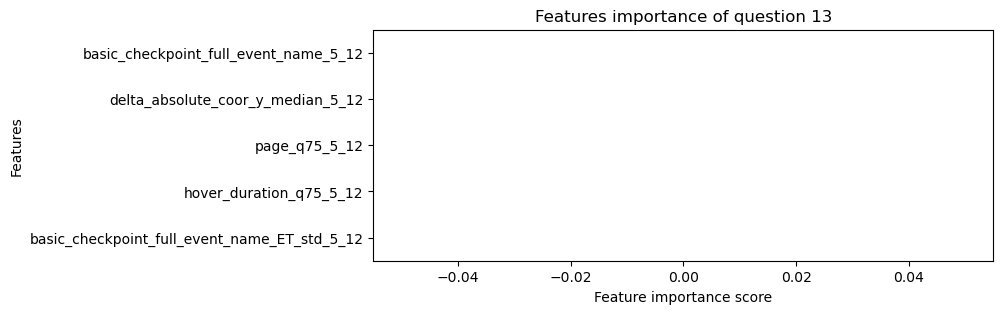

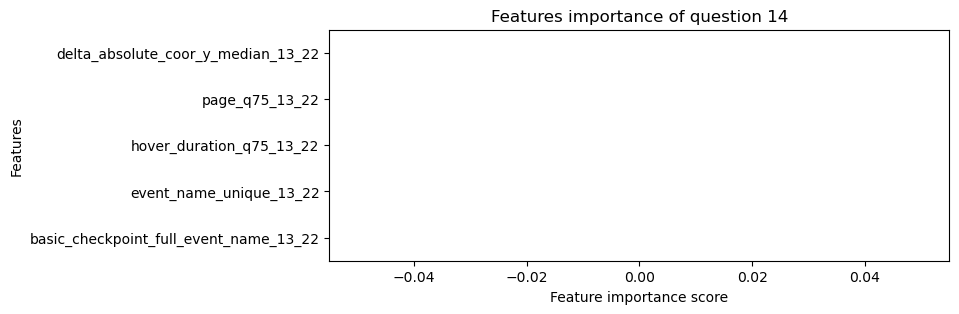

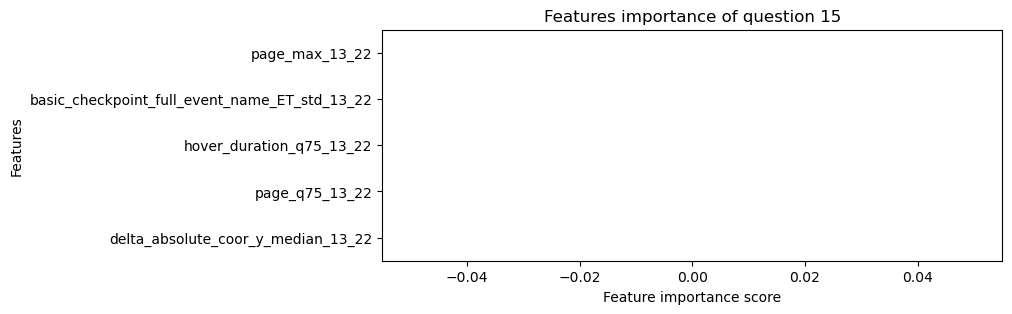

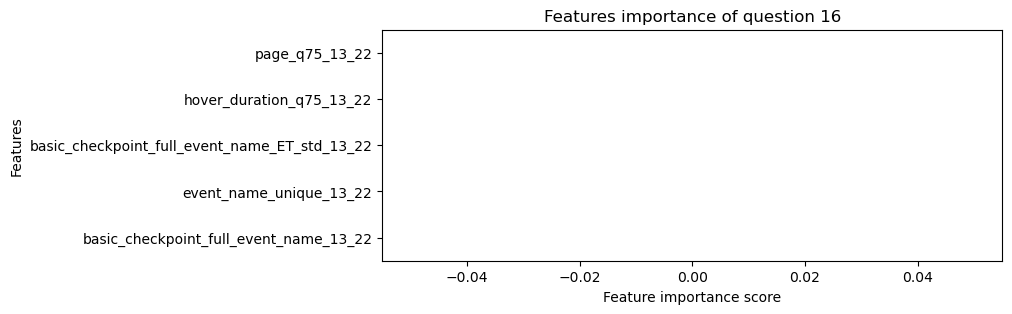

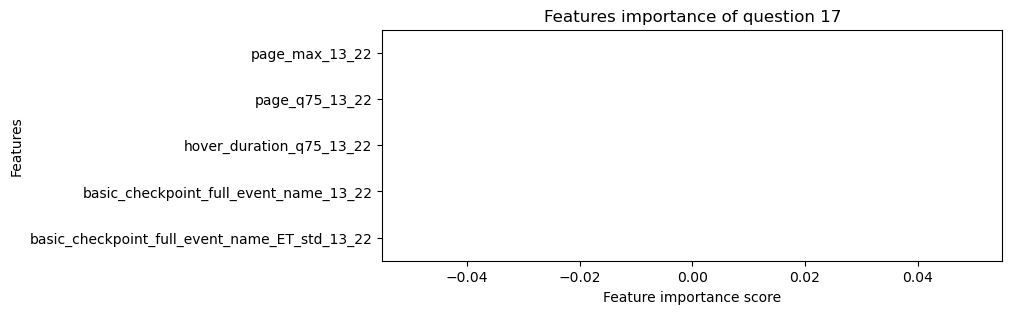

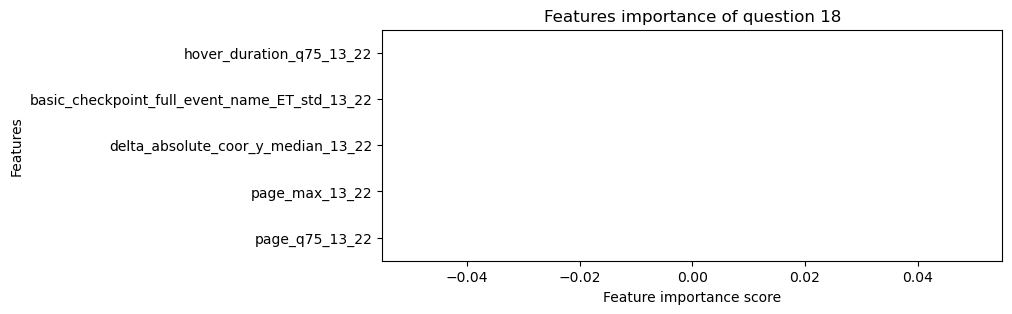

In [21]:
for q in range(1, 19):
    plotLeastImportances(q)

In [23]:
# Set feature for each question
def getFeaturesByQuestion(q:int, ratio):
    nfeatures = int(len(feature_scores[f"{q}"])*ratio)
    return feature_scores[f"{q}"][:nfeatures].index.to_list()

FEATURES_Q = []
for q in range(1, 19):
    ratio = 0.5
    FEATURES_Q.append(getFeaturesByQuestion(q, ratio))

with open("FEATURES_Q.csv", "w") as f:
    for q in FEATURES_Q:
        f.writelines(' '.join(str(i) for i in q))
        f.writelines("\n")

In [39]:
with open("/kaggle/working/FEATURES_Q.csv", "r") as f:
    FEATURES_Q = [f.readline().split() for i in range(1,19)]

In [26]:
# Boruta
kf = KFold(n_splits=10)
feature_rank={}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(kf.split(df1)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        FEATURES = FEATURES_Q[t-1]
        if t<=3: 
            grp = '0-4'
            
            # TRAIN DATA
            train_x = df1.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df1.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        elif t<=13: 
            grp = '5-12'
            # TRAIN DATA
            train_x = df2.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df2.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        elif t<=22: 
            grp = '13-22'
            # TRAIN DATA
            train_x = df3.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df3.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
    
        #BORUTA
        SHADOW_FEATURE = [f'{x}_shadow' for x in FEATURES]
        for index, value in enumerate(SHADOW_FEATURE):
            train_x[value] = np.random.permutation(train_x[FEATURES[index]])
            valid_x[value] = np.random.permutation(valid_x[FEATURES[index]])
        
        # TRAIN MODEL        
        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x[FEATURES+SHADOW_FEATURE].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES+SHADOW_FEATURE].astype('float32'), valid_y['correct']) ],
                verbose=0)

        #BORUTA
        max_rank_shadow = max(clf.feature_importances_[len(FEATURES):])
        print(f'Max rank shadow: {max_rank_shadow}')
        feature_rank[f'fold_{i}_q_{t}'] = pd.DataFrame({"Feature":FEATURES, f'Rank_{i}':map(lambda x: 1 if x >max_rank_shadow else 0,clf.feature_importances_[:len(FEATURES)])}).set_index('Feature')       
    
    print()

#########################
### Fold 1
#########################
Max rank shadow: 40
Max rank shadow: 58
Max rank shadow: 50
Max rank shadow: 38
Max rank shadow: 40
Max rank shadow: 49
Max rank shadow: 44
Max rank shadow: 51
Max rank shadow: 44
Max rank shadow: 48
Max rank shadow: 41
Max rank shadow: 52
Max rank shadow: 52
Max rank shadow: 40
Max rank shadow: 44
Max rank shadow: 45
Max rank shadow: 44
Max rank shadow: 50

#########################
### Fold 2
#########################
Max rank shadow: 40
Max rank shadow: 57
Max rank shadow: 44
Max rank shadow: 59
Max rank shadow: 47
Max rank shadow: 38
Max rank shadow: 46
Max rank shadow: 70
Max rank shadow: 57
Max rank shadow: 52
Max rank shadow: 53
Max rank shadow: 75
Max rank shadow: 58
Max rank shadow: 48
Max rank shadow: 40
Max rank shadow: 62
Max rank shadow: 51
Max rank shadow: 40

#########################
### Fold 3
#########################
Max rank shadow: 42
Max rank shadow: 67
Max rank shadow: 49
Max rank shadow: 46
Max rank 

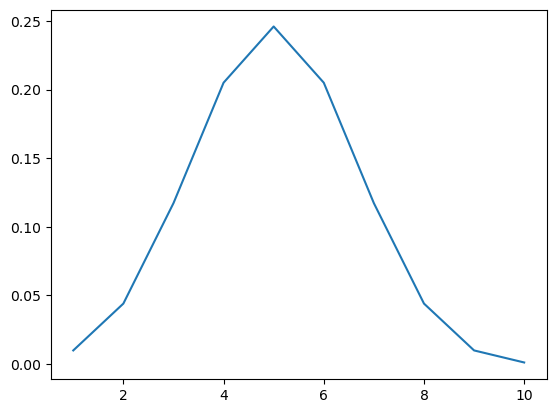

In [27]:
import math
def binomal_probably(n,k,p):
   return math.comb(n,k)*p**k*(1-p)**(n-k)
plt.plot(range(1,11), [binomal_probably(10,x,0.5) for x in range(1,11)])

In [40]:

for t in range(1,19):
    FEATURES = FEATURES_Q[t-1]
    feature_hits = pd.DataFrame(data=FEATURES,columns=["feature"]).set_index("feature")
    for i in range(10):
        feature_hits=feature_hits.join(feature_rank[f'fold_{i}_q_{t}'])
    feature_hits=feature_hits.apply(np.sum, axis=1)
    print(feature_hits)
    FEATURES_Q[t-1]=[]
    for f in FEATURES:
        if feature_hits[f]>3:
            FEATURES_Q[t-1].append(f)
    print(FEATURES_Q[t-1])

feature
basic_cutscene_click_full_event_name_ET_median_0_4    10
4_level_ET_max_0_4                                    10
4_level_ET_sum_0_4                                    10
basic_checkpoint_full_event_name_ET_sum_0_4           10
2_level_ET_median_0_4                                 10
                                                      ..
3_level_ET_max_0_4                                     0
basic_map_hover_full_event_name_ET_sum_0_4             0
room_coor_y_mean_0_4                                   0
undefined_map_click_full_event_name_ET_std_0_4         0
basic_cutscene_click_full_event_name_0_4               0
Length: 115, dtype: int64
['basic_cutscene_click_full_event_name_ET_median_0_4', '4_level_ET_max_0_4', '4_level_ET_sum_0_4', 'basic_checkpoint_full_event_name_ET_sum_0_4', '2_level_ET_median_0_4', 'basic_checkpoint_full_event_name_ET_max_0_4', 'basic_object_click_full_event_name_0_4', 'basic_checkpoint_full_event_name_ET_mean_0_4', '3_level_0_4', 'basic_person_cl

In [41]:
for t in range(1,19):
    FEATURES = FEATURES_Q[t-1]
    print(f'Question {t} count: {len(FEATURES)}')

Question 1 count: 26
Question 2 count: 7
Question 3 count: 8
Question 4 count: 18
Question 5 count: 28
Question 6 count: 20
Question 7 count: 22
Question 8 count: 6
Question 9 count: 22
Question 10 count: 19
Question 11 count: 16
Question 12 count: 7
Question 13 count: 13
Question 14 count: 22
Question 15 count: 36
Question 16 count: 5
Question 17 count: 7
Question 18 count: 12


In [42]:
# Re-train model
kf = KFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}
importants = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(kf.split(df1)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        FEATURES = FEATURES_Q[t-1]
        if t<=3: 
            grp = '0-4'
            
            # TRAIN DATA
            train_x = df1.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df1.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        elif t<=13: 
            grp = '5-12'
            # TRAIN DATA
            train_x = df2.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df2.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        elif t<=22: 
            grp = '13-22'
            # TRAIN DATA
            train_x = df3.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df3.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
    
        # TRAIN MODEL        
        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{i}_{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################

#########################
### Fold 2
#########################

#########################
### Fold 3
#########################

#########################
### Fold 4
#########################

#########################
### Fold 5
#########################



0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

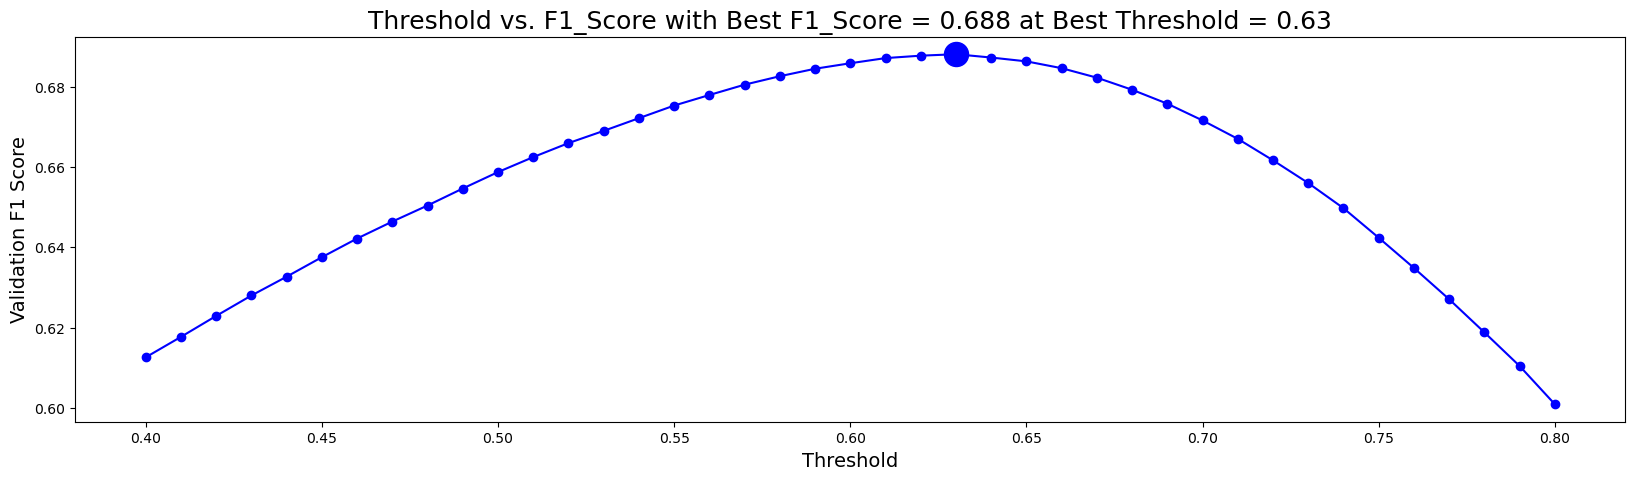

In [43]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [44]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6658369140541021
Q1: F1 = 0.5004093228501517
Q2: F1 = 0.5095195615581236
Q3: F1 = 0.6620398818872084
Q4: F1 = 0.6089014069987713
Q5: F1 = 0.6221221333596778
Q6: F1 = 0.6142658258176242
Q7: F1 = 0.5509354665731829
Q8: F1 = 0.6162943955490983
Q9: F1 = 0.5442564014636211
Q10: F1 = 0.5995863074054346
Q11: F1 = 0.5116484773317191
Q12: F1 = 0.46033432483687065
Q13: F1 = 0.618808508376842
Q14: F1 = 0.5515994891841389
Q15: F1 = 0.48950179000400856
Q16: F1 = 0.5494851729563837
Q17: F1 = 0.4945613199902763
==> Overall F1 = 0.6882121577308706
